# Cargue y preentrenamiento de datos

In [1]:
Etiquetas_Nombres = ['baseball_field', 'basketball_court', 'football_field', 'golf_course', 'tennis_court']

In [2]:
import os
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

def cargar_imagenes_con_etiquetas(ruta_dataset):
    imagenes = []
    etiquetas = []
    
    for etiqueta in os.listdir(ruta_dataset):
        carpeta = os.path.join(ruta_dataset, etiqueta)
        if os.path.isdir(carpeta):
            for archivo in os.listdir(carpeta):
                if archivo.endswith('.tif') or archivo.endswith('.png') or archivo.endswith('.jpg'):
                    img_path = os.path.join(carpeta, archivo)
                    img = Image.open(img_path)
                    imagenes.append(np.array(img)) 
                    etiquetas.append(etiqueta)
    
    return imagenes, etiquetas

def obtener_tamanios_por_etiqueta(imagenes, etiquetas):
    tamanios_por_etiqueta = {}
    for img, etiqueta in zip(imagenes, etiquetas):
        tamanio = img.shape[:2]
        if etiqueta not in tamanios_por_etiqueta:
            tamanios_por_etiqueta[etiqueta] = set()
        tamanios_por_etiqueta[etiqueta].add(tamanio)
    return tamanios_por_etiqueta

def redimensionar_imagenes(imagenes, nuevo_tamanio):
    imagenes_redimensionadas = []
    for img in imagenes:
        img_pil = Image.fromarray(img)
        img_redimensionada = img_pil.resize(nuevo_tamanio, Image.ANTIALIAS)
        imagenes_redimensionadas.append(np.array(img_redimensionada))
    return imagenes_redimensionadas

def verificar_tamanio(imagenes):
    tamanio_referencia = None
    for img in imagenes:
        if tamanio_referencia is None:
            tamanio_referencia = img.shape[:2]
        else:
            if img.shape[:2] != tamanio_referencia:
                return False
    return True

def normalizar_imagenes(imagenes):
    imagenes_array = np.array(imagenes)
    imagenes_normalizadas = imagenes_array / 255.0
    media = np.mean(imagenes_normalizadas, axis=(0, 1, 2))
    imagenes_normalizadas -= media
    return imagenes_normalizadas


In [3]:
# Cargar y procesar las imágenes
ruta_dataset = 'C:/Users/nicol/Desktop/Universidad/Dataset_Utiles/PatternNet'
imagenes, etiquetas = cargar_imagenes_con_etiquetas(ruta_dataset)

# Obtener tamaños por etiqueta antes de redimensionar
tamanios_por_etiqueta = obtener_tamanios_por_etiqueta(imagenes, etiquetas)

tamanios_por_etiqueta


{'baseball_field': {(256, 256)},
 'basketball_court': {(256, 256)},
 'football_field': {(256, 256)},
 'golf_course': {(256, 256)},
 'tennis_court': {(256, 256)}}

In [4]:
nuevo_tamanio = (256, 256)
imagenes_redimensionadas = redimensionar_imagenes(imagenes, nuevo_tamanio)

if verificar_tamanio(imagenes_redimensionadas):
    print("Todas las imágenes tienen el mismo tamaño.")
else:
    print("Las imágenes tienen diferentes tamaños.")
    
imagenes_normalizadas = normalizar_imagenes(imagenes_redimensionadas)

C:\Users\nicol\AppData\Local\Temp\ipykernel_14632\279961940.py:36: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img_redimensionada = img_pil.resize(nuevo_tamanio, Image.ANTIALIAS)


Todas las imágenes tienen el mismo tamaño.


In [5]:
# Codificar las etiquetas
codificacion = {'baseball_field': 0, 'basketball_court': 1, 'football_field': 2, 'golf_course': 3, 'tennis_court': 4}
etiquetas_codificadas = np.array([codificacion[etiqueta] for etiqueta in etiquetas])

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(imagenes_normalizadas, etiquetas_codificadas, test_size=0.2, random_state=42)

# Aplanar las imágenes para el sobremuestreo
n_samples, height, width, channels = X_train.shape
X_train_2d = X_train.reshape((n_samples, -1))

# Mostrar la distribución de clases antes del balanceo
unique, counts = np.unique(y_train, return_counts=True)
print("Distribución de clases en el conjunto de entrenamiento antes del balanceo:")
print(dict(zip(unique, counts)))


Distribución de clases en el conjunto de entrenamiento antes del balanceo:
{0: 629, 1: 623, 2: 644, 3: 658, 4: 646}


In [6]:
# Aplicar sobremuestreo aleatorio
ros = RandomOverSampler(random_state=42)
X_train_res_2d, y_train_res = ros.fit_resample(X_train_2d, y_train)

# Reconstruir las imágenes a su forma original
X_train_res = X_train_res_2d.reshape((-1, height, width, channels))

# Mostrar la distribución de clases después del balanceo
unique_res, counts_res = np.unique(y_train_res, return_counts=True)
print("Distribución de clases en el conjunto de entrenamiento después del balanceo:")
print(dict(zip(unique_res, counts_res)))


Distribución de clases en el conjunto de entrenamiento después del balanceo:
{0: 658, 1: 658, 2: 658, 3: 658, 4: 658}


In [7]:
# Imprimir el tamaño de los conjuntos de entrenamiento y prueba
print("Número de ejemplos de entrenamiento antes del balanceo:", len(X_train))
print("Número de ejemplos de entrenamiento después del balanceo:", len(X_train_res))
print("Número de ejemplos de prueba:", len(X_test))

Número de ejemplos de entrenamiento antes del balanceo: 3200
Número de ejemplos de entrenamiento después del balanceo: 3290
Número de ejemplos de prueba: 800


# Entrenamiento modelo customizado

In [8]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.callbacks import EarlyStopping, LearningRateScheduler
import numpy as np
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Crear un modelo secuencial
modelo = Sequential()

# Agregar capas al modelo
modelo.add(Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))
modelo.add(MaxPooling2D((2, 2)))
modelo.add(Conv2D(64, (3, 3), activation='relu'))
modelo.add(MaxPooling2D((2, 2)))
modelo.add(Flatten())
modelo.add(Dense(64, activation='relu'))
modelo.add(Dense(5, activation='softmax'))

# Compilar el modelo
modelo.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Mostrar un resumen del modelo
modelo.summary()

# Función para reducir el learning rate en cada época
def scheduler(epoch, lr):
    if epoch < 3:
        return lr
    else:
        return lr * np.exp(-0.1)

# Crear el callback EarlyStopping para detener el entrenamiento si la métrica no mejora
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    verbose=1,
    restore_best_weights=True
)

# Entrenar el modelo
historial_entrenamiento = modelo.fit(X_train_res, y_train_res, epochs=10, validation_data=(X_train_res, y_train_res))

# Predecir las etiquetas para el conjunto de prueba
y_pred_prob = modelo.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)



c:\Users\nicol\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 246016)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │    15,745,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,764,805 (60.14 MB)

 Trainable params: 15,764,805 (60.14 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 91s 877ms/step - accuracy: 0.6063 - loss: 1.0555 - val_accuracy: 0.8930 - val_loss: 0.2920
Epoch 2/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 83s 804ms/step - accuracy: 0.9040 - loss: 0.2651 - val_accuracy: 0.9471 - val_loss: 0.1720
Epoch 3/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 84s 815ms/step - accuracy: 0.9599 - loss: 0.1224 - val_accuracy: 0.9894 - val_loss: 0.0366
Epoch 4/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 88s 851ms/step - accuracy: 0.9934 - loss: 0.0320 - val_accuracy: 0.9976 - val_loss: 0.0194
Epoch 5/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 88s 850ms/step - accuracy: 0.9971 - loss: 0.0146 - val_accuracy: 0.9964 - val_loss: 0.0142
Epoch 6/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 91s 881ms/step - accuracy: 0.9939 - loss: 0.0211 - val_accuracy: 1.0000 - val_loss: 0.0019
Epoch 7/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 86s 836ms/step - accuracy: 0.9993 - loss: 0.0053 - val_accuracy: 0.9991 - val_loss: 0.0034
Epoch 8/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 86s 840ms/step - accuracy: 0.9988 - loss: 0

Precision: 0.9029843543598001
Recall: 0.9025
F1 Score: 0.902664896686137
Accuracy: 0.9025
Classification Report:
                  precision    recall  f1-score   support

  baseball_field       0.96      0.94      0.95       171
basketball_court       0.84      0.83      0.83       177
  football_field       0.92      0.93      0.93       156
     golf_course       0.95      0.96      0.95       142
    tennis_court       0.85      0.87      0.86       154

        accuracy                           0.90       800
       macro avg       0.90      0.90      0.90       800
    weighted avg       0.90      0.90      0.90       800



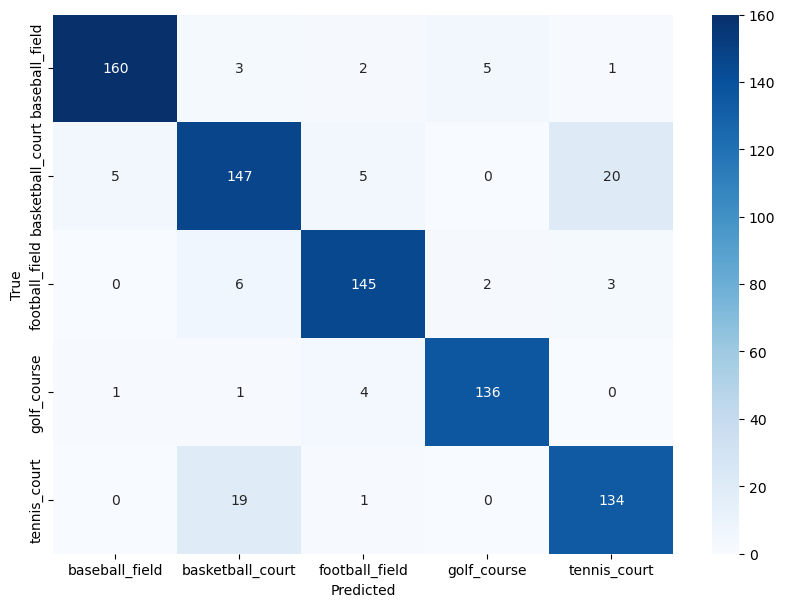

In [9]:
# Calcular la precisión, recall, f1 score y accuracy
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
accuracy = accuracy_score(y_test, y_pred)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")

# Obtener un informe detallado de clasificación
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=Etiquetas_Nombres))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=Etiquetas_Nombres, yticklabels=Etiquetas_Nombres)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [10]:
# Supongamos que `model` es tu modelo entrenado
modelo.save('C:/Users/nicol/Desktop/Modelos/PatternNET/PatternNET_Custom.h5')

# Entrenamiento con VGG16

In [12]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

# Función para reducir el learning rate en cada época
def scheduler(epoch, lr):
    if epoch < 3:
        return lr
    else:
        return lr * np.exp(-0.1)

# Crear el callback EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Métrica a monitorear
    patience=3,          # Número de épocas sin mejora para detener el entrenamiento
    verbose=1,           # Muestra mensajes en la salida estándar
    restore_best_weights=True  # Restaurar los pesos del modelo en su mejor punto
)

# Crear el callback LearningRateScheduler
lr_scheduler = LearningRateScheduler(scheduler)

# Cargar el modelo VGG16 
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Congelar las capas del modelo base
for layer in base_model.layers:
    layer.trainable = False

# Añadir nuevas capas superiores
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(5, activation='softmax')(x)  

#******************************************************************************************

# Crear el modelo completo
model = Model(inputs=base_model.input, outputs=predictions)

# Compilar el modelo
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


# Entrenar el modelo con los callbacks
model.fit(
    X_train_res, 
    y_train_res, 
    epochs=10, 
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, lr_scheduler]  # Agregar los callbacks aquí
)
#******************************************************************************************




Epoch 1/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 362s 3s/step - accuracy: 0.6780 - loss: 1.1831 - val_accuracy: 0.9463 - val_loss: 0.1644 - learning_rate: 0.0010
Epoch 2/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 325s 3s/step - accuracy: 0.9248 - loss: 0.2164 - val_accuracy: 0.9488 - val_loss: 0.1360 - learning_rate: 0.0010
Epoch 3/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 318s 3s/step - accuracy: 0.9394 - loss: 0.1552 - val_accuracy: 0.9663 - val_loss: 0.0898 - learning_rate: 0.0010
Epoch 4/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 319s 3s/step - accuracy: 0.9532 - loss: 0.1244 - val_accuracy: 0.9650 - val_loss: 0.0891 - learning_rate: 9.0484e-04
Epoch 5/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 322s 3s/step - accuracy: 0.9667 - loss: 0.0896 - val_accuracy: 0.9688 - val_loss: 0.0843 - learning_rate: 8.1873e-04
Epoch 6/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 321s 3s/step - accuracy: 0.9779 - loss: 0.0624 - val_accuracy: 0.9663 - val_loss: 0.0889 - learning_rate: 7.4082e-04
Epoch 7/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 322s 3s/step - accuracy: 0.975

25/25 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step
Precision: 0.9690106559243474
Recall: 0.96875
F1 Score: 0.9687434992909527
Accuracy: 0.96875
Classification Report:
                  precision    recall  f1-score   support

  baseball_field       0.99      0.96      0.98       171
basketball_court       0.95      0.94      0.95       177
  football_field       0.94      0.99      0.97       156
     golf_course       0.99      0.99      0.99       142
    tennis_court       0.97      0.96      0.97       154

        accuracy                           0.97       800
       macro avg       0.97      0.97      0.97       800
    weighted avg       0.97      0.97      0.97       800



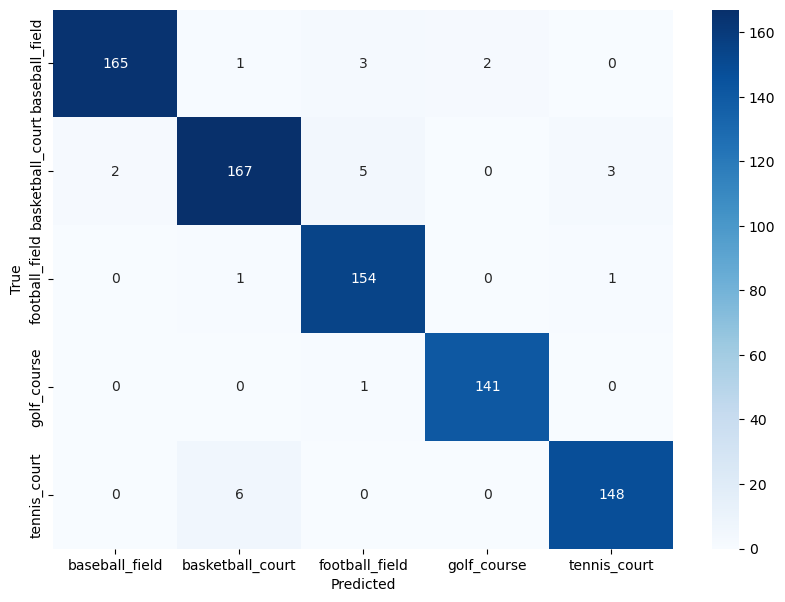

In [13]:
# Evaluar el modelo
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# Calcular las métricas
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
accuracy = accuracy_score(y_test, y_pred)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")

# Obtener un informe detallado de clasificación
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=Etiquetas_Nombres))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=Etiquetas_Nombres, yticklabels=Etiquetas_Nombres)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [14]:
# Supongamos que `model` es tu modelo entrenado
model.save('C:/Users/nicol/Desktop/Modelos/PatternNET/PatternNET_VGG16.h5')

# Modelo Preentrenado Xception con ImageNet

In [15]:
import tensorflow as tf
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping, LearningRateScheduler
import numpy as np

# Función para reducir el learning rate en cada época
def scheduler(epoch, lr):
    if epoch < 3:
        return lr
    else:
        return lr * np.exp(-0.1)

# Crear el callback EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Métrica a monitorear
    patience=3,          # Número de épocas sin mejora para detener el entrenamiento
    verbose=1,           # Muestra mensajes en la salida estándar
    restore_best_weights=True  # Restaurar los pesos del modelo en su mejor punto
)

# Crear el callback LearningRateScheduler
lr_scheduler = LearningRateScheduler(scheduler)

# Cargar el modelo Xception 
base_model = Xception(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Congelar las capas del modelo base
for layer in base_model.layers:
    layer.trainable = False

# Añadir nuevas capas superiores
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(5, activation='softmax')(x)  

#*********************************************************************************************

# Crear el modelo completo
model = Model(inputs=base_model.input, outputs=predictions)

# Compilar el modelo
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Entrenar el modelo con los callbacks
model.fit(
    X_train_res, 
    y_train_res, 
    epochs=10, 
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, lr_scheduler]  # Agregar los callbacks aquí
)

Epoch 1/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 310s 3s/step - accuracy: 0.7684 - loss: 3.5778 - val_accuracy: 0.9688 - val_loss: 0.0916 - learning_rate: 0.0010
Epoch 2/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 316s 3s/step - accuracy: 0.9446 - loss: 0.1758 - val_accuracy: 0.9638 - val_loss: 0.0943 - learning_rate: 0.0010
Epoch 3/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 314s 3s/step - accuracy: 0.9361 - loss: 0.2108 - val_accuracy: 0.9787 - val_loss: 0.0660 - learning_rate: 0.0010
Epoch 4/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 314s 3s/step - accuracy: 0.9642 - loss: 0.1173 - val_accuracy: 0.9762 - val_loss: 0.0971 - learning_rate: 9.0484e-04
Epoch 5/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 313s 3s/step - accuracy: 0.9649 - loss: 0.1348 - val_accuracy: 0.9725 - val_loss: 0.0702 - learning_rate: 8.1873e-04
Epoch 6/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 316s 3s/step - accuracy: 0.9706 - loss: 0.1004 - val_accuracy: 0.9800 - val_loss: 0.0548 - learning_rate: 7.4082e-04
Epoch 7/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 314s 3s/step - accuracy: 0.977

25/25 ━━━━━━━━━━━━━━━━━━━━ 66s 3s/step
Precision: 0.9838332939909457
Recall: 0.98375
F1 Score: 0.9837659762682155
Accuracy: 0.98375
Classification Report:
                  precision    recall  f1-score   support

  baseball_field       0.99      0.99      0.99       171
basketball_court       0.97      0.98      0.97       177
  football_field       0.99      0.99      0.99       156
     golf_course       1.00      0.98      0.99       142
    tennis_court       0.97      0.98      0.98       154

        accuracy                           0.98       800
       macro avg       0.98      0.98      0.98       800
    weighted avg       0.98      0.98      0.98       800



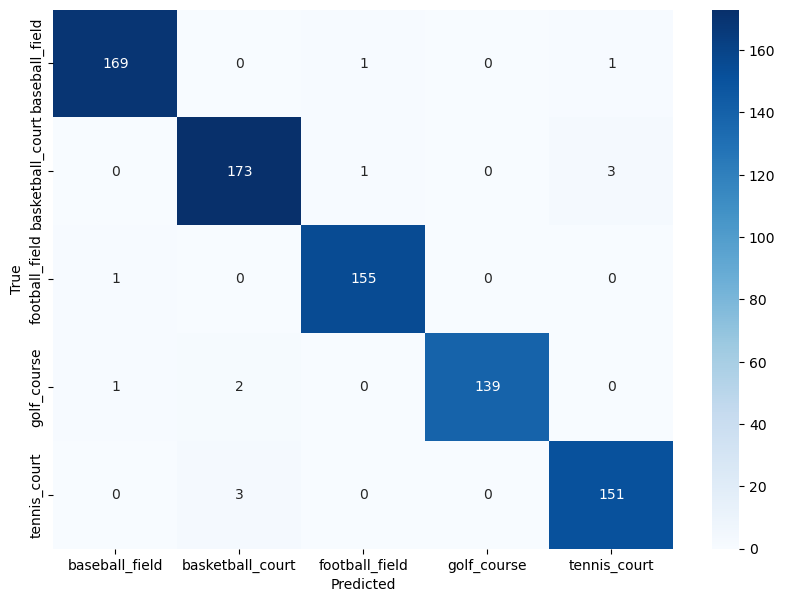

In [16]:
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score

# Evaluar el modelo
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# Calcular las métricas
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
accuracy = accuracy_score(y_test, y_pred)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")

# Obtener un informe detallado de clasificación
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names= Etiquetas_Nombres))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=Etiquetas_Nombres, yticklabels=Etiquetas_Nombres)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [17]:
# Supongamos que `model` es tu modelo entrenado
model.save('C:/Users/nicol/Desktop/Modelos/PatternNET/PatternNET_Xception.h5')

# Entrenamiento con MobileNet Preentrenado con Imagenet

In [2]:
import os
from PIL import Image
import numpy as np
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

# Definir las etiquetas
Etiquetas_Nombres = ['baseball_field', 'basketball_court', 'football_field', 'golf_course', 'tennis_court']

# Función para cargar imágenes y etiquetas
def cargar_imagenes_con_etiquetas(ruta_dataset, nuevo_tamanio=(256, 256)):
    imagenes = []
    etiquetas = []
    
    for etiqueta in os.listdir(ruta_dataset):
        carpeta = os.path.join(ruta_dataset, etiqueta)
        if os.path.isdir(carpeta):
            for archivo in os.listdir(carpeta):
                if archivo.endswith('.tif') or archivo.endswith('.png') or archivo.endswith('.jpg'):
                    img_path = os.path.join(carpeta, archivo)
                    img = Image.open(img_path).convert('RGB')  # Asegurarse de que todas las imágenes estén en RGB
                    img = img.resize(nuevo_tamanio)  # Redimensionar para garantizar que todas tengan el mismo tamaño
                    imagenes.append(np.array(img))  # Convertir a numpy array
                    etiquetas.append(etiqueta)
    
    return imagenes, etiquetas

# Cargar y procesar las imágenes
ruta_dataset = 'C:/Users/nicol/Desktop/Universidad/Dataset_Utiles/PatternNET'
imagenes, etiquetas = cargar_imagenes_con_etiquetas(ruta_dataset)

# Codificar las etiquetas
codificacion = {'baseball_field': 0, 'basketball_court': 1, 'football_field': 2, 'golf_course': 3, 'tennis_court': 4}
etiquetas_codificadas = np.array([codificacion[etiqueta] for etiqueta in etiquetas])

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(imagenes, etiquetas_codificadas, test_size=0.2, random_state=42)

# Convertir las imágenes a arrays de numpy
X_train_np = np.array(X_train)
height, width, channels = X_train_np.shape[1:]  # Obtener las dimensiones de las imágenes

# Aplanar las imágenes para el sobremuestreo
X_train_2d = X_train_np.reshape(len(X_train_np), -1)

# Aplicar sobremuestreo aleatorio
ros = RandomOverSampler(random_state=42)
X_train_res_2d, y_train_res = ros.fit_resample(X_train_2d, y_train)

# Reconstruir las imágenes a su forma original después del sobremuestreo
X_train_res = X_train_res_2d.reshape(-1, height, width, channels)

# Definir las transformaciones con normalización y redimensionamiento
transform = transforms.Compose([
    transforms.ToPILImage(),  # Convertir de numpy array a PIL image
    transforms.Resize((256, 256)),  # Redimensionar la imagen
    transforms.ToTensor(),  # Convertir de PIL a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalización de ImageNet
])

# Custom Dataset con transformaciones
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)  # Aplicar transformaciones
        return image, label

# Crear los datasets de entrenamiento y prueba
train_dataset = CustomDataset(X_train_res, y_train_res.astype(int), transform=transform)
test_dataset = CustomDataset(X_test, y_test.astype(int), transform=transform)

# Crear DataLoaders
batch_size = 32
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Entrenamiento y evaluación del modelo
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Cargar el modelo MobileNet preentrenado
model = models.mobilenet_v2(pretrained=True)

# Reemplazar la última capa del modelo para adaptarse a nuestro número de clases (5 en este caso)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 5)

# Mover el modelo a la GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Definir la función de pérdida y el optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Cambiar el scheduler a StepLR para reducir cada 3 épocas
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Early stopping variables
best_loss = np.Inf
patience = 3
epochs_no_improve = 0
early_stop = False

# Entrenamiento del modelo
num_epochs = 15
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device, dtype=torch.long)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    epoch_loss = running_loss / len(trainloader)
    print(f'Epoch {epoch+1}, Loss: {epoch_loss}')
    
    # Validación
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device, dtype=torch.long)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    
    val_loss /= len(testloader)
    print(f'Validation Loss: {val_loss}')
    
    scheduler.step()
    
    if val_loss < best_loss:
        best_loss = val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
    
    if epochs_no_improve >= patience:
        print('Early stopping triggered')
        early_stop = True
        break

    if early_stop:
        break


c:\Users\nicol\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\nicol\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1, Loss: 0.1685069486390329
Validation Loss: 0.031436129226349294
Epoch 2, Loss: 0.08084781556525855
Validation Loss: 0.0197270340914838
Epoch 3, Loss: 0.06574039907478366
Validation Loss: 0.027977504222653805
Epoch 4, Loss: 0.020307563646251192
Validation Loss: 0.016446867874474264
Epoch 5, Loss: 0.013179206772248523
Validation Loss: 0.013912959874141961
Epoch 6, Loss: 0.010125467773143753
Validation Loss: 0.013015255027567037
Epoch 7, Loss: 0.005786577049186182
Validation Loss: 0.01335576210229192
Epoch 8, Loss: 0.005330867800597119
Validation Loss: 0.012949928631715011
Epoch 9, Loss: 0.004144297028723335
Validation Loss: 0.013744009791116696
Epoch 10, Loss: 0.0072059212741329
Validation Loss: 0.013569072137470358
Epoch 11, Loss: 0.006544610518776785
Validation Loss: 0.013283493324415759
Early stopping triggered


Precision: 0.9950337912087913
Recall: 0.995
F1 Score: 0.9950019244868035
Accuracy: 0.995
Classification Report:
                  precision    recall  f1-score   support

  baseball_field       1.00      1.00      1.00       171
basketball_court       0.99      0.98      0.99       177
  football_field       1.00      1.00      1.00       156
     golf_course       1.00      1.00      1.00       142
    tennis_court       0.98      0.99      0.99       154

        accuracy                           0.99       800
       macro avg       1.00      1.00      1.00       800
    weighted avg       1.00      0.99      1.00       800



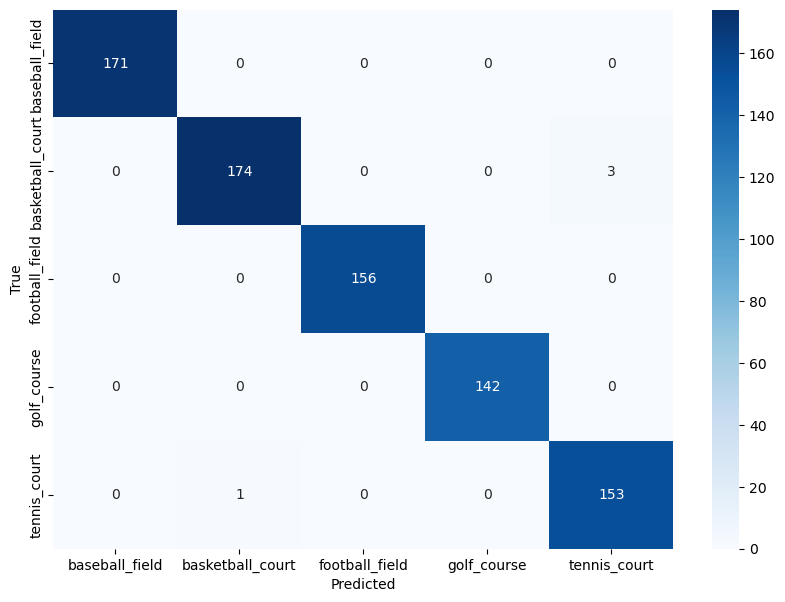

In [5]:
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluación del modelo
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in testloader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Calcular las métricas
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')
accuracy = accuracy_score(all_labels, all_preds)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")

# Obtener un informe detallado de clasificación
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=Etiquetas_Nombres))

# Matriz de confusión
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=Etiquetas_Nombres,
            yticklabels=Etiquetas_Nombres)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [6]:
# Guardar el modelo completo
torch.save(model, 'C:/Users/nicol/Desktop/Modelos/PatternNET/PatternNET_mobileNET.pth')

# Entrenamiento con Resnet18 Preentrenado con Imagenet

In [7]:
import os
from PIL import Image
import numpy as np
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

# Definir las etiquetas
Etiquetas_Nombres = ['baseball_field', 'basketball_court', 'football_field', 'golf_course', 'tennis_court']

# Función para cargar imágenes y etiquetas
def cargar_imagenes_con_etiquetas(ruta_dataset, nuevo_tamanio=(256, 256)):
    imagenes = []
    etiquetas = []
    
    for etiqueta in os.listdir(ruta_dataset):
        carpeta = os.path.join(ruta_dataset, etiqueta)
        if os.path.isdir(carpeta):
            for archivo in os.listdir(carpeta):
                if archivo.endswith('.tif') or archivo.endswith('.png') or archivo.endswith('.jpg'):
                    img_path = os.path.join(carpeta, archivo)
                    img = Image.open(img_path).convert('RGB')  # Asegurarse de que todas las imágenes estén en RGB
                    img = img.resize(nuevo_tamanio)  # Redimensionar para garantizar que todas tengan el mismo tamaño
                    imagenes.append(np.array(img))  # Convertir a numpy array
                    etiquetas.append(etiqueta)
    
    return imagenes, etiquetas

# Cargar y procesar las imágenes
ruta_dataset = 'C:/Users/nicol/Desktop/Universidad/Dataset_Utiles/PatternNET'
imagenes, etiquetas = cargar_imagenes_con_etiquetas(ruta_dataset)

# Codificar las etiquetas
codificacion = {'baseball_field': 0, 'basketball_court': 1, 'football_field': 2, 'golf_course': 3, 'tennis_court': 4}
etiquetas_codificadas = np.array([codificacion[etiqueta] for etiqueta in etiquetas])

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(imagenes, etiquetas_codificadas, test_size=0.2, random_state=42)

# Convertir las imágenes a arrays de numpy
X_train_np = np.array(X_train)
height, width, channels = X_train_np.shape[1:]  # Obtener las dimensiones de las imágenes

# Aplanar las imágenes para el sobremuestreo
X_train_2d = X_train_np.reshape(len(X_train_np), -1)

# Aplicar sobremuestreo aleatorio
ros = RandomOverSampler(random_state=42)
X_train_res_2d, y_train_res = ros.fit_resample(X_train_2d, y_train)

# Reconstruir las imágenes a su forma original después del sobremuestreo
X_train_res = X_train_res_2d.reshape(-1, height, width, channels)

# Definir las transformaciones con normalización y redimensionamiento
transform = transforms.Compose([
    transforms.ToPILImage(),  # Convertir de numpy array a PIL image
    transforms.Resize((256, 256)),  # Redimensionar la imagen
    transforms.ToTensor(),  # Convertir de PIL a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalización de ImageNet
])

# Custom Dataset con transformaciones
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)  # Aplicar transformaciones
        return image, label

# Crear los datasets de entrenamiento y prueba
train_dataset = CustomDataset(X_train_res, y_train_res.astype(int), transform=transform)
test_dataset = CustomDataset(X_test, y_test.astype(int), transform=transform)

# Crear DataLoaders
batch_size = 32
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Entrenamiento y evaluación del modelo
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Cargar el modelo ResNet18 preentrenado
model = models.resnet18(pretrained=True)

# Reemplazar la última capa (fully connected layer) de ResNet18 para adaptarse a nuestro número de clases (5 en este caso)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 5)

# Mover el modelo a la GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Definir la función de pérdida y el optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Cambiar el scheduler a StepLR para reducir cada 3 épocas
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Early stopping variables
best_loss = np.Inf
patience = 3
epochs_no_improve = 0
early_stop = False

# Entrenamiento del modelo
num_epochs = 15
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device, dtype=torch.long)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    epoch_loss = running_loss / len(trainloader)
    print(f'Epoch {epoch+1}, Loss: {epoch_loss}')
    
    # Validación
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device, dtype=torch.long)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    
    val_loss /= len(testloader)
    print(f'Validation Loss: {val_loss}')
    
    scheduler.step()
    
    if val_loss < best_loss:
        best_loss = val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
    
    if epochs_no_improve >= patience:
        print('Early stopping triggered')
        early_stop = True
        break

    if early_stop:
        break


c:\Users\nicol\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\nicol\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1, Loss: 0.25895188855531726
Validation Loss: 2.0422925996780394
Epoch 2, Loss: 0.08103083862100267
Validation Loss: 0.05267496511340141
Epoch 3, Loss: 0.04796206114307335
Validation Loss: 0.09654024592600763
Epoch 4, Loss: 0.026693402730195232
Validation Loss: 0.03280262139160186
Epoch 5, Loss: 0.011684979137216323
Validation Loss: 0.025282003772445022
Epoch 6, Loss: 0.009397333988284656
Validation Loss: 0.023808651580475272
Epoch 7, Loss: 0.0046910825095058065
Validation Loss: 0.021340398745960557
Epoch 8, Loss: 0.004626899612366756
Validation Loss: 0.02243730549700558
Epoch 9, Loss: 0.004662183422518406
Validation Loss: 0.02264210184570402
Epoch 10, Loss: 0.004874118059835153
Validation Loss: 0.023185077634407206
Early stopping triggered


Precision: 0.992604788213628
Recall: 0.9925
F1 Score: 0.9924925573360777
Accuracy: 0.9925
Classification Report:
                  precision    recall  f1-score   support

  baseball_field       1.00      1.00      1.00       171
basketball_court       0.97      0.99      0.98       177
  football_field       1.00      1.00      1.00       156
     golf_course       1.00      1.00      1.00       142
    tennis_court       0.99      0.97      0.98       154

        accuracy                           0.99       800
       macro avg       0.99      0.99      0.99       800
    weighted avg       0.99      0.99      0.99       800



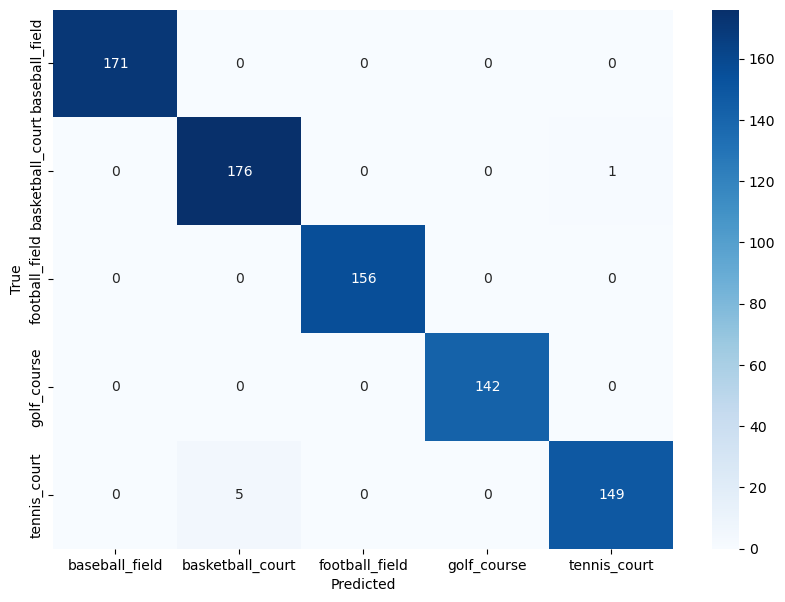

In [10]:

from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluación del modelo
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in testloader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Calcular las métricas
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')
accuracy = accuracy_score(all_labels, all_preds)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")

# Obtener un informe detallado de clasificación
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=Etiquetas_Nombres))

# Matriz de confusión
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=Etiquetas_Nombres,
            yticklabels=Etiquetas_Nombres)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [11]:
# Guardar el modelo completo
torch.save(model, 'C:/Users/nicol/Desktop/Modelos/PatternNET/PatternNET_ResNET18.pth')